# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
# all imports here

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
import re
import math
import calendar
import datetime
import random

from calendar import monthrange
from sklearn import datasets, linear_model, ensemble
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
DATA_FOLDER = './Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.("/")

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

### Path extracting
- First, we need to collect into an array every file name where the data is located
- We will separate the data of each country at first, because they do not follow the same conventions and change the columns name that we are interested in into the same ones for each country.
- We'll finally merge them as requested for the rest of the computations.

In [3]:
country_folder_names = ['guinea_data', 'liberia_data', 'sl_data']
country_paths = [DATA_FOLDER + '/ebola/' + name for name in country_folder_names]

# all files about the ebola task (by country)
all_ebola_files = [glob.glob(os.path.join(path, "*.csv")) for path in country_paths]

### Data reading
Using the paths we extracted above, we read and then merge the data into 3 `Dataframes`, one for each country. Finally we add a column to each `Dataframe` containing the name of the country the data comes from

In [4]:
guinea_files = all_ebola_files[0]
guinea_df = pd.concat([pd.read_csv(path) for path in guinea_files], axis=0).rename(
    columns={'Date': 'Date', 'Description': 'Info', 'Totals': 'Total'})
guinea_df['Country'] = 'Guinea' 
#'Total deaths of confirmed' | 'Total cases of confirmed'

liberia_files = all_ebola_files[1]
liberia_df = pd.concat([pd.read_csv(path) for path in liberia_files], axis=0).rename(
    columns={'Date': 'Date', 'Variable': 'Info', 'National': 'Total'})
liberia_df['Country'] = 'Liberia' 
# 'Total death/s in confirmed cases' | 'Total confirmed cases'

sl_files = all_ebola_files[2]
sl_df = pd.concat([pd.read_csv(path) for path in sl_files], axis=0).rename(
    columns={'date': 'Date', 'variable': 'Info', 'National': 'Total'})
sl_df['Country'] = 'Sierra Leone'
#'death_confirmed' | 'cum_confirmed'  || totals

We then merge the three Dataframes into one and replace missing values by 0.

In [5]:
ebola_df = pd.concat(
    [
        guinea_df,
        liberia_df,
        sl_df
    ],
    axis=0
)

# replace missing values by 0
ebola_df.fillna('0', inplace=True)

The values in the date column are not all in the same format, therefore we need to uniformize their format.<br/>
Then, we set the index of the `Dataframe` into a combination of the country and the date.

In [6]:
# unify dates
ebola_df['Date'] = pd.to_datetime(ebola_df['Date'])

# build index
ebola_df.index = [ebola_df['Country'], ebola_df['Date']]
ebola_df.index.rename(['Country', 'Date_index'], inplace=True)

In [7]:
# displaying some
ebola_df[:5]

34 Military Hospital Beyla Bo Bo EMC Boffa Bombali  \
Country Date_index                                                      
Guinea  2014-08-27                    0     0  0      0     0       0   
        2014-08-27                    0     0  0      0     0       0   
        2014-08-27                    0     0  0      0     0       0   
        2014-08-27                    0     0  0      0     0       0   
        2014-08-27                    0     0  0      0     0       0   

                   Bomi County Bong County Bonthe Conakry  ...  Sinoe County  \
Country Date_index                                         ...                 
Guinea  2014-08-27           0           0      0       0  ...             0   
        2014-08-27           0           0      0       0  ...             0   
        2014-08-27           0           0      0       4  ...             0   
        2014-08-27           0           0      0       4  ...             0   
        2014-08-27           0           0      0       8  ...             0   

                   Telimele Tonkolili Total Unnamed: 18 Western area  \
Country Date_index                                                     
Guinea  2014-08-27        0         0    12           0            0   
        2014-08-27        0         0     0           0            0   
        2014-08-27        0         0    10           0            0   
        2014-08-27        0         0    22           0            0   
        2014-08-27        0         0    22           0            0   

                   Western area combined Western area rural  \
Country Date_index                                            
Guinea  2014-08-27                     0                  0   
        2014-08-27                     0                  0   
        2014-08-27                     0                  0   
        2014-08-27                     0                  0   
        2014-08-27                     0                  0   

                   Western area urban Yomou  
Country Date_index                           
Guinea  2014-08-27                  0     1  
        2014-08-27                  0     0  
        2014-08-27                  0     0  
        2014-08-27                  0     1  
        2014-08-27                  0     1  

[5 rows x 65 columns]

### Assumption
- We will assume that for each row the total sum is contained in the column named "Total". Therefore if there is a difference between the value in the column "Total" and the sum of the values in the other columns, the ground truth resides in the value in the column "Total".
Based on this assumption, only the columns "Info" and the "Total" will be used.

In [8]:
ebola_df = ebola_df[['Total', 'Info']]

In [9]:
# displaying some rows
ebola_df[:5]

Total                               Info
Country Date_index                                         
Guinea  2014-08-27    12              New cases of suspects
        2014-08-27     0             New cases of probables
        2014-08-27    10             New cases of confirmed
        2014-08-27    22  Total new cases registered so far
        2014-08-27    22            Total cases of suspects

### Assumptions
We will assume from now on that:
- Only data of confirmed cases and deaths is reliable and important. Therefore we will ignore 'suspected' and 'probable' cases in our calculations.
- The descriptions 'Total deaths of confirmed', 'Total death/s in confirmed cases' and 'death_confirmed', 'Total cases of confirmed', 'Total confirmed cases' and 'cum_confirmed' are cumulative totals.
- The descriptions 'Total deaths of confirmed', 'Total death/s in confirmed cases' and 'death_confirmed' contain data about the number of death of people that we were sure had Ebola.
- The descriptions 'Total cases of confirmed', 'Total confirmed cases' and 'cum_confirmed' contain data about the number of cases of people that we are sure have Ebola.

### Reasoning
We could have chosen the daily counts instead of cumulative counts. However, they were not always given in all countries which means that we couldn't have used a uniform method of computation for every country. <br>
Moreover, using culumative is sufficient and easier. It is also more consistent.

Following our assumptions, we need to keep the results concerned by the mentionned descriptions only.<br><br>
Furthermore, some entries containing the data do not only constitute of numbers, but of '%' or ',', those characters need to be removed.

In [10]:
deaths_info_to_keep = ['Total deaths of confirmed', 'Total death/s in confirmed cases', 'death_confirmed']
cases_info_to_keep = ['Total cases of confirmed', 'Total confirmed cases', 'cum_confirmed']

ebola_df['Total'] = pd.to_numeric(ebola_df['Total'].replace(',|%', '', regex=True))
ebola_df['Deads'] = np.where(ebola_df['Info'].isin(deaths_info_to_keep), ebola_df['Total'], 0)
ebola_df['Cases'] = np.where(ebola_df['Info'].isin(cases_info_to_keep), ebola_df['Total'], 0)

# displaying some data the dataframe
ebola_df.head(20)

Total                                             Info  \
Country Date_index                                                           
Guinea  2014-08-27   12.0                            New cases of suspects   
        2014-08-27    0.0                           New cases of probables   
        2014-08-27   10.0                           New cases of confirmed   
        2014-08-27   22.0                Total new cases registered so far   
        2014-08-27   22.0                          Total cases of suspects   
        2014-08-27  142.0                         Total cases of probables   
        2014-08-27  499.0                         Total cases of confirmed   
        2014-08-27  663.0     Cumulative (confirmed + probable + suspects)   
        2014-08-27  518.0                  Total suspected non-class cases   
        2014-08-27    2.0                            New deaths registered   
        2014-08-27    2.0                         Total deaths of suspects   
        2014-08-27  142.0                        Total deaths of probables   
        2014-08-27  294.0                        Total deaths of confirmed   
        2014-08-27  438.0  Total deaths (confirmed + probables + suspects)   
        2014-08-27   66.0        Fatality rate for confirmed and probables   
        2014-08-27    0.0      New cases of confirmed among health workers   
        2014-08-27   45.0     Total case of confirmed among health workers   
        2014-08-27    0.0       New deaths registered among health workers   
        2014-08-27   26.0     Total deaths registered among health workers   
        2014-08-27   12.0                         New admits to CTE so far   

                    Deads  Cases  
Country Date_index                
Guinea  2014-08-27    0.0    0.0  
        2014-08-27    0.0    0.0  
        2014-08-27    0.0    0.0  
        2014-08-27    0.0    0.0  
        2014-08-27    0.0    0.0  
        2014-08-27    0.0    0.0  
        2014-08-27    0.0  499.0  
        2014-08-27    0.0    0.0  
        2014-08-27    0.0    0.0  
        2014-08-27    0.0    0.0  
        2014-08-27    0.0    0.0  
        2014-08-27    0.0    0.0  
        2014-08-27  294.0    0.0  
        2014-08-27    0.0    0.0  
        2014-08-27    0.0    0.0  
        2014-08-27    0.0    0.0  
        2014-08-27    0.0    0.0  
        2014-08-27    0.0    0.0  
        2014-08-27    0.0    0.0  
        2014-08-27    0.0    0.0

In [11]:
countries = ['Guinea', 'Liberia', 'Sierra Leone']
infos = ['Deads', 'Cases']

# we don't need the "Total" and "Info" columns anymore
ebola_infos_df = ebola_df[infos]

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


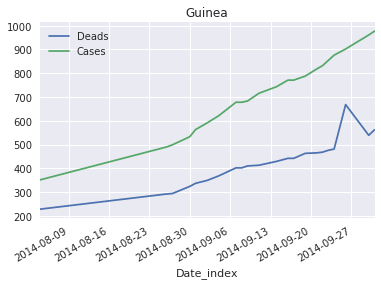

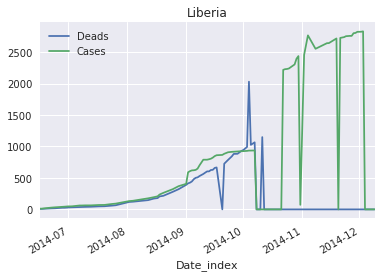

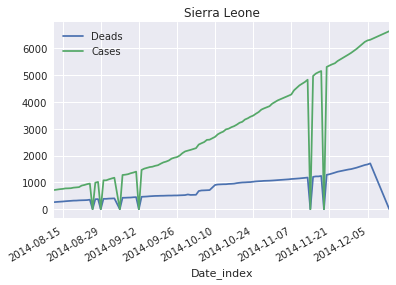

In [12]:
# plotting data by country

for country in countries:
    ebola_infos_df.loc[country].groupby(['Date_index']).agg(sum).plot(title=country)

As we can see above, lots of data is missing where y = 0, we will need to ignore those point in the future. Moreover, some points seem to be incorrect unless one can resuscitate.


### Methods

To get better estimations and ignore unrealistic values, we will create and train a model to detect outliers and create another one to create an extrapolation. We will use a RANSAC Regressor to detect the outliers and an ExtraTreesRegressor to extrapolate the values.<br/>


#### Alternatives

We could have used a LinearRegressor instead of the ExtraTreesRegressor, this would have lead to a better approximation of the trend and it could also compensate human error induced during data fetching. However, we are more interested in the exact daily average given by the data knowing that outliers are taken care of by the RANSAC Regressor and thus the error is  minimal enough to be ignored.

In [13]:
day_offset = datetime.datetime(2014, 1, 1,)

def days_in_month(year, month):
    return monthrange(year, month)[1]

def days_in_interval(start, end):
    return (end.total_seconds() - start.total_seconds()) / (3600 * 24)

# example : delta of 35 days would return "February"
def days_delta_to_month(days):
    return calendar.month_name[math.floor(days/30) + 1]

Since data is sometimes missing, we then extract the intervals for each country where we have data about the number of cases, and where we have the number of deads.

For each of those intervals:
- we get the length in days for each month in the interval.
- we create pairs for each month in the interval, where the first item is the earliest day of that month contained in the interval, and the second one, the latest one.

In [14]:
def build_interval_by_month(start, end):
    assert(start.year == end.year) # works within the same year only
    assert(start.month < end.month ) # can't go backwards or same month
    
    interval = []
        
    # corner case #1 : start.day is not the first of the month
    interval.append([
        datetime.datetime(start.year, start.month, start.day),
        datetime.datetime(start.year, start.month, days_in_month(start.year, start.month))
    ])
    for month_idx in range(start.month + 1, end.month):
        interval.append([
            datetime.datetime(start.year, month_idx, 1),
            datetime.datetime(start.year, month_idx, days_in_month(start.year, month_idx))
        ])
    # corner case #2 : end.day in not necessary the last of the month
    interval.append([
        datetime.datetime(end.year, end.month, 1),
        datetime.datetime(end.year, end.month, end.day)
    ])
    
    return [[date-day_offset for date in dates]  for dates in interval]


In [15]:
intervals_of_interest = {}
                        
for country in countries:
    intervals_of_interest[country] = {}
    for info in infos:
        agg_data = ebola_infos_df.loc[country].groupby(['Date_index']).agg(sum)
        agg_data_greater_zero = agg_data[agg_data[info]>0]
        start = agg_data_greater_zero.index[0]
        end = agg_data_greater_zero.index[-1]
        intervals_of_interest[country][info] = build_interval_by_month(start, end)


To train our models, we created some new features to complement the only one we have. The primary feature being the date in seconds of the record since a previously decided day offset (beginning of the year) divided by 100'000.

In [16]:
def get_features(dates):
    X = pd.DataFrame(
        data=[date.total_seconds() for date in dates],
        index=range(len(dates)),
        columns=['Date_index']
    )
    
    X["Date_index"] = X["Date_index"] / 100000.
    X["log"] = X["Date_index"].apply(np.log)
    X["Date1/2"] = X["Date_index"]**(1/2.)
    X["Date^2"] = X["Date_index"]**2
    return X

In [17]:
# note : it also plots the predictions 
def get_model(country, info):
    agg_data = ebola_infos_df.loc[country].groupby(['Date_index']).agg(sum)
    agg_data_greater_zero = agg_data[agg_data[info] > 0]
    
    delta = pd.DataFrame(agg_data_greater_zero[info].index)["Date_index"] - day_offset
    
    X = get_features(delta.tolist())
    
    reg1 = linear_model.RANSACRegressor(random_state=1024)
    reg2 = ensemble.ExtraTreesRegressor(random_state=1411)
    
    reg1.fit(X, agg_data_greater_zero[info])
    inlier_mask = reg1.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    x_train, x_test, y_train, y_test = train_test_split(X[inlier_mask], agg_data_greater_zero[info][inlier_mask], test_size=0.0)
    reg2.fit(x_train, y_train)

    pred_df = pd.DataFrame(reg2.predict(X)).rename(columns={0:"Prediction"})
    pred_df["Real Values (zeroes filtered)"] = agg_data_greater_zero[info].values
    pred_df["Date"] = agg_data_greater_zero.index
    pred_df.plot(x="Date", title=country+' - '+info)
    return reg2

In [18]:
def plot_info_per_month(intervals, plot_name):
    intervals_df = pd.DataFrame(
        data=[interval[0] for interval in intervals],
        index=[interval[1] for interval in intervals],
    )
    intervals_df.index.name = "Months"
    
    intervals_df.plot(kind="bar", title=plot_name, legend=False)

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


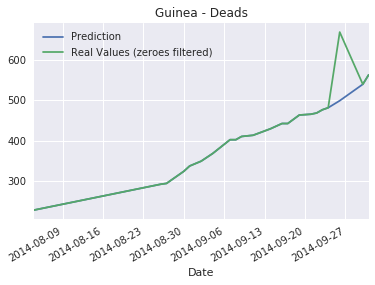

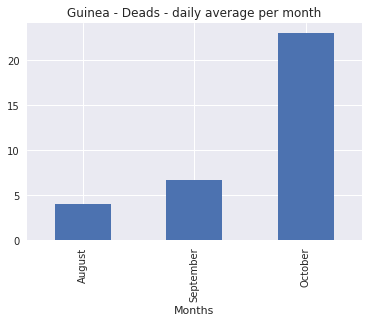

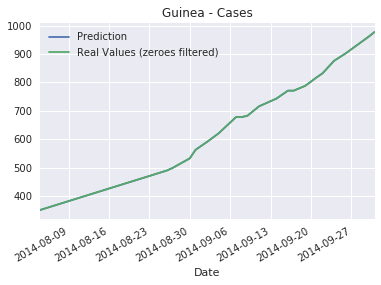

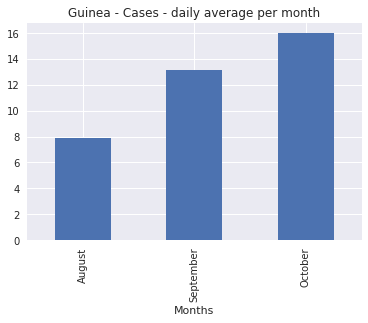

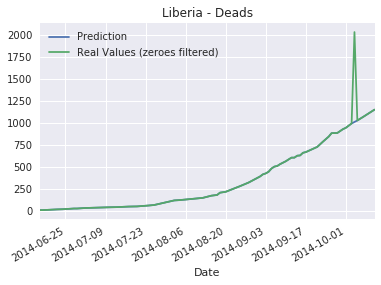

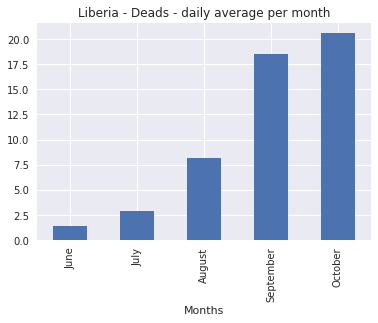

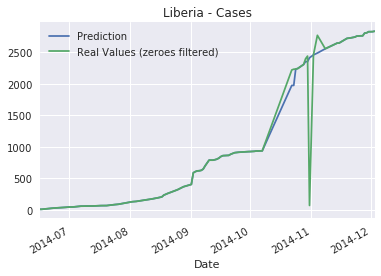

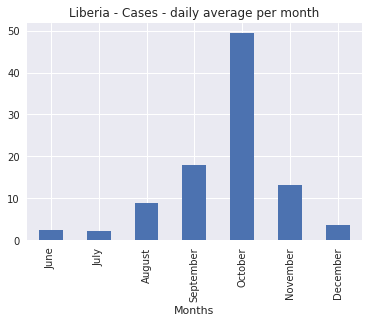

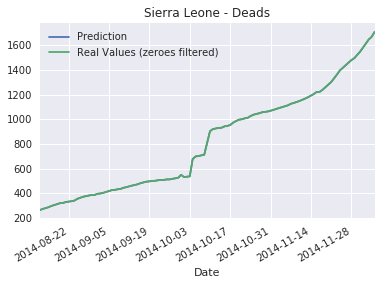

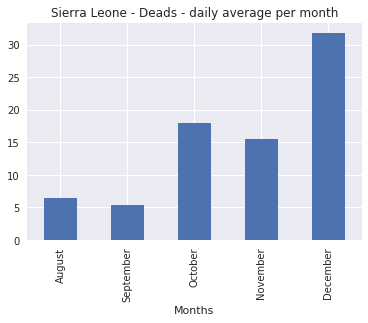

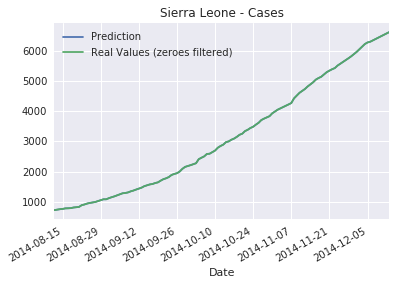

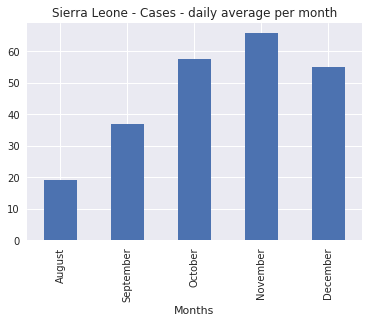

In [19]:
pred = [] 
for country in countries:
    for info in infos:
        model = get_model(country, info)
        intervals = []
        for interval in intervals_of_interest[country][info]:
            features = get_features(interval)
            pred.append(model.predict(features))
            if(interval[0] == interval[1]):
                intervals.append([pred[-1][1] - pred[-2][1], days_delta_to_month(interval[0].days)])
            else:
                intervals.append([
                    (pred[-1][1] - pred[-1][0]) / days_in_interval(interval[0], interval[1]),
                     days_delta_to_month(interval[0].days)
                ])
        plot_info_per_month(intervals, country + " - " + info + " - daily average per month")

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

### Our solution

-> We import the metadata into a dataframe


-> We import each data files (MIDx.xls) into dataframes (1 file = 1 dataframe) <br/>
note: we handle the first column as row indices and then use it to concat the different dataframes


-> For each data files, we add their respective index that we get from the dataframe of the metadata <br/>
note: it's said we must add it as columns, we assumed it was as column names for each data source which makes lots of sense


-> We concat rows of the MIDs dataframes in one single dataframe


-> We replace NaN values by "unknown"

reading all filenames in the folder ending with .xls

In [20]:
task2_files = glob.glob(os.path.join(DATA_FOLDER+'/microbiome/', "*.xls"))
task2_files.sort()
task2_files

['./Data/microbiome/MID1.xls',
 './Data/microbiome/MID2.xls',
 './Data/microbiome/MID3.xls',
 './Data/microbiome/MID4.xls',
 './Data/microbiome/MID5.xls',
 './Data/microbiome/MID6.xls',
 './Data/microbiome/MID7.xls',
 './Data/microbiome/MID8.xls',
 './Data/microbiome/MID9.xls',
 './Data/microbiome/metadata.xls']

Thanks to the sort, we can see that the metadata is at the end of the list. Hence we extract it using this info.

separating data file paths (0 to 8) and metadata file path (last = 9)

In [21]:
metadata_file = task2_files[-1]
mids_files = task2_files[:-1]

importing metadata file into a dataframe and showing it

In [22]:
metadata_df = pd.read_excel(metadata_file, index_col=None)

metadata_df

,BARCODE,GROUP,SAMPLE
0,MID1,EXTRACTION CONTROL,NaN
1,MID2,NEC 1,tissue
2,MID3,Control 1,tissue
3,MID4,NEC 2,tissue
4,MID5,Control 2,tissue
5,MID6,NEC 1,stool
6,MID7,Control 1,stool
7,MID8,NEC 2,stool
8,MID9,Control 2,stool


note: we can check the that the order of the rows is the same as the order of the files (MID1 -> MID9).

This makes it easy to associate file with its corresponding colum name using indices :

In [23]:
mids_df = []
for idx, file in enumerate(mids_files):
    mids_df.append(pd.read_excel(file, index_col=0, header=None))
    mids_df[idx].columns = [[index] for index in metadata_df.loc[range(len(metadata_df)), ["GROUP", "SAMPLE"]].T[idx]]
                   
mids_df[3][:5]

,NEC 2
,tissue
0,
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",2
"Archaea ""Crenarchaeota"" Thermoprotei Sulfolobales Sulfolobaceae Sulfurisphaera",1
"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Methanocellales Methanocellaceae Methanocella",1
"Archaea ""Euryarchaeota"" Archaeoglobi Archaeoglobales Archaeoglobaceae Ferroglobus",1
"Archaea ""Euryarchaeota"" Methanopyri Methanopyrales Methanopyraceae Methanopyrus",10


(above : showing dataframe samples of file MID4.xls) 

concat of the 9 dataframes into one (concat by row) and NA are being replaced by "unknown"

In [24]:
mids_df_concat = pd.concat(mids_df, axis=1)
mids_df_concat.fillna(value="unknown", inplace=True)

mids_df_concat

,EXTRACTION CONTROL,NEC 1,Control 1,NEC 2,Control 2,NEC 1,Control 1,NEC 2,Control 2
,NaN,tissue,tissue,tissue,tissue,stool,stool,stool,stool
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Acidilobaceae Acidilobus",unknown,2,1,unknown,5,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera",unknown,14,15,unknown,26,unknown,1,unknown,1
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",7,23,14,2,28,7,8,unknown,16
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Stetteria",unknown,unknown,unknown,unknown,1,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus",unknown,1,4,unknown,5,1,2,unknown,2
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermodiscus",unknown,unknown,1,unknown,unknown,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermosphaera",unknown,2,1,unknown,2,unknown,1,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Hyperthermus",unknown,1,unknown,unknown,unknown,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrodictium",unknown,unknown,3,unknown,2,1,1,unknown,5


(above : showing final dataframe)

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [25]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

### Data loading

In [26]:
data = pd.read_excel(DATA_FOLDER+'/titanic.xls')

In [27]:
data.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [28]:
data.describe(include='all')

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
count,1309.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307,486,121.000000,745
unique,NaN,NaN,1307,2,NaN,NaN,NaN,939,NaN,186,3,28,NaN,369
top,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S,13,NaN,"New York, NY"
freq,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914,39,NaN,64
mean,2.294882,0.381971,NaN,NaN,29.881135,0.498854,0.385027,NaN,33.295479,NaN,NaN,NaN,160.809917,NaN
std,0.837836,0.486055,NaN,NaN,14.413500,1.041658,0.865560,NaN,51.758668,NaN,NaN,NaN,97.696922,NaN
min,1.000000,0.000000,NaN,NaN,0.166700,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,1.000000,NaN
25%,2.000000,0.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN,NaN,72.000000,NaN
50%,3.000000,0.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,NaN,155.000000,NaN
75%,3.000000,1.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN,NaN,256.000000,NaN


## 1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`.

### Data description
- *pclass*: is an Integer between 1 and 3 that represents in which class that passenger was in. It can be categorical because we cannot say that 3rd class is twice as far as 2nd class from 1st class.
- *survived*: is an Integer that tells us whether the passenger survived (1) or died (0). Even though it should be categorical, it is easier to let it non-categorical as it is then possible to sum the values to get the total number of people who survived.
- *name*: is a String that contains the name of the passenger. The title could be extracted from this attribute and be transformed into a categorical attribut but we don't use it here.
- *sex*: is String that is either 'female' or 'male'. It contains the information about the sex of the passenger. It can be categorical.
- *age*: is a Double that represents the age in year of the passenger. It could be transformed into ranges and which could then be considered as categorical.
- *sibsp*: is an Integer that contains the number of siblings and spouse also embarked aboard the Titanic.
- *parch*: is an Integer that contains the number of children and parents also embarked aboard the Titanic.
- *ticket*: is a String that contains the ticket number of the passenger.
- *fare*: is an Integer that represents the price that the passenger paid for its ticket.
- *cabin*: is a String that contains the deck letter and the cabin number of the passenger.
- *embarked*: is a character {S, Q, C} that represent the Port where the passenger embarked.
- *boat*: is the id of the boat that the passenger took after the Titanic crashed into the iceberg.
- *body*: is the number attributed to a dead body when it was found.
- *home.dest*:  represents two informations: before the / is the home of the person and after the / is the destination of the person.

In [29]:
data['pclass'] = data.pclass.astype('category')
data['sex'] = data.sex.astype('category')
data['embarked'] = data.embarked.astype('category')

## 2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


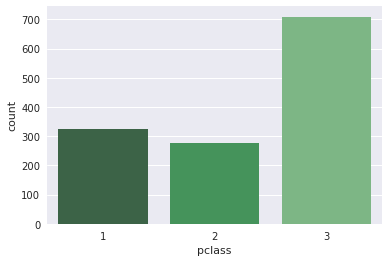

In [30]:
sns.countplot(x="pclass", data=data, palette="Greens_d")

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


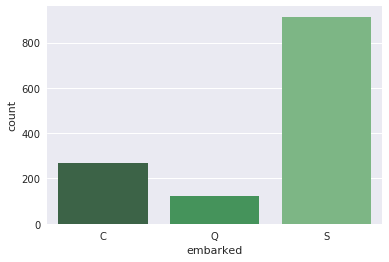

In [31]:
sns.countplot(x="embarked", data=data, palette="Greens_d")

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


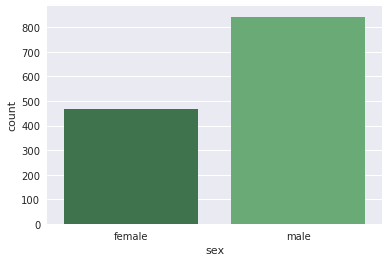

In [32]:
sns.countplot(x="sex", data=data, palette="Greens_d")

For the discrete interval, we decide to divide the ages in 9 intervals: 1 for each decades from 0 to 90 years old. Thanks to the use of panda cut function we do not have to bother about NAs.

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


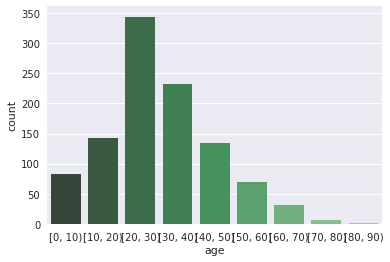

In [33]:
sns.countplot(x=pd.cut(data.age, [0,10,20,30,40,50,60,70,80,90], right=False), palette="Greens_d")

## 3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.

Let's first plot a pie for every values we have for the cabin floors.

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


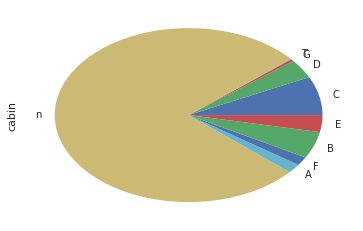

In [34]:
data['cabin'].astype(str).str[0].value_counts(sort=False).plot(kind='pie')

As we can see above, around 3/4 of the data is missing for this attribute. We need to ignore the missing values to have a better view of the pie chart. Note that the cabin floor T might seem to be a typo, we will assume it refers to the tank top that one can find on a titanic deckplan and hence keep the value.

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


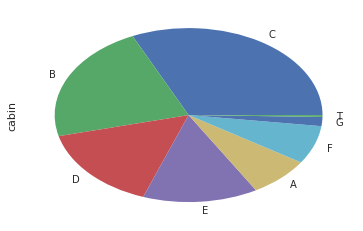

In [35]:
data['cabin'].astype(str).str[0].value_counts()[1:].plot(kind='pie')

## 4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdfd9928128>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fdfd9618908>], dtype=object)

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


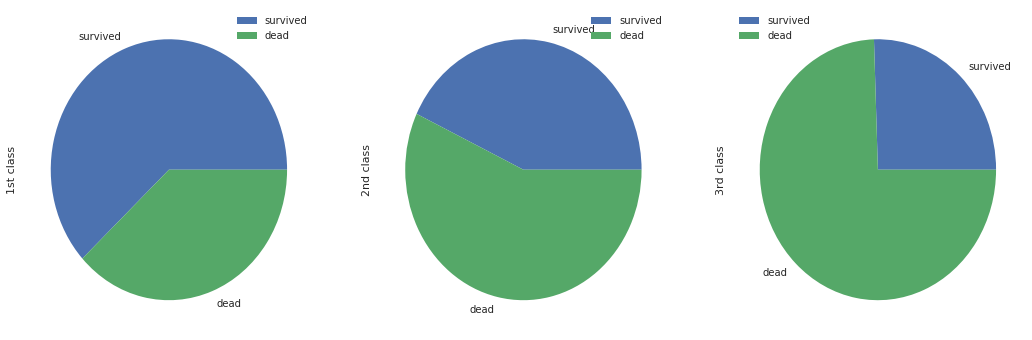

In [36]:
df=data.groupby("pclass").survived.agg(["sum", lambda x: len(x) - sum(x)])
df.columns=["survived", "dead"]
df=df.T
df.columns=["1st class", "2nd class", "3rd class"]
df.plot(kind="pie", subplots=True, figsize=(18, 6))

## 5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.

Seaborn allows us to plot such a graph. The black bars show the variance.

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


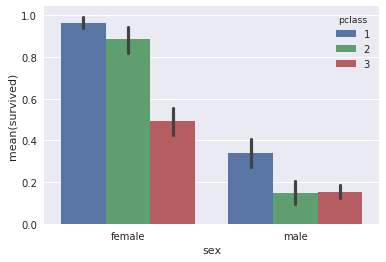

In [37]:
sns.barplot(x="sex", y="survived", hue="pclass", data=data);

### 6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

To split the datas in two equally populated age categories, we use the median and group the data on both side of the median. Obviously some datas will reside in the median and hence we will not get two perfectly equally populated categories but we assume that considering the number of datas we have, we condiser a small delta is acceptable

In [38]:
df = data[['pclass', 'sex', 'age', 'survived']][data['age'].isnull() != True]
median_age = df[['age']].median()
df['age_cat'] = np.where(df[['age']] > median_age, '>{}'.format(median_age[0]), '<{}'.format(median_age[0]))
df = df[['pclass', 'sex', 'age_cat', 'survived']]
df.groupby(['age_cat', 'pclass', 'sex']).agg(np.mean)

survived
age_cat pclass sex             
<28.0   1      female  0.951220
               male    0.531250
        2      female  0.910714
               male    0.216216
        3      female  0.513761
               male    0.183036
>28.0   1      female  0.967391
               male    0.302521
        2      female  0.872340
               male    0.083333
        3      female  0.372093
               male    0.144000